# Airbnb Case Study (Price Regression)

https://www.kaggle.com/datasets/kritikseth/us-airbnb-open-data

This project uses a comprehensive U.S. Airbnb listings dataset to develop accurate price prediction models. Effective price prediction benefits multiple stakeholders: hosts can optimize pricing strategies to maximize revenue and occupancy rates, while Airbnb can improve its recommendation systems and pricing tools to increase user satisfaction and bookings.

Price prediction is valuable across industries, helping businesses understand pricing drivers, optimize offerings, and improve revenue management. For customers, it promotes pricing transparency and fairness.

The technical approach combines exploratory data analysis to identify key price drivers and outliers, feature engineering to create meaningful variables, and target transformations to handle skewed price distributions. Modeling methods include linear regression for interpretable baselines and ensemble techniques like Gradient Boosting and XGBoost for capturing complex patterns. Model explainability tools such as SHAP will translate predictions into actionable business insights.

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import warnings
warnings.filterwarnings("ignore")
import folium
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
import shap

In [2]:
df = pd.read_csv('AB_US_2023.csv')

In [4]:
df.head().T

,0,1,2,3,4
id,958,5858,8142,8339,8739
name,"Bright, Modern Garden Unit - 1BR/1BTH",Creative Sanctuary,Friendly Room Apt. Style -UCSF/USF - San Franc...,Historic Alamo Square Victorian,"Mission Sunshine, with Private Bath"
host_id,1169,8904,21994,24215,7149
host_name,Holly,Philip And Tania,Aaron,Rosy,Ivan & Wendy
neighbourhood_group,NaN,NaN,NaN,NaN,NaN
neighbourhood,Western Addition,Bernal Heights,Haight Ashbury,Western Addition,Mission
latitude,37.77028,37.74474,37.76555,37.77564,37.7603
longitude,-122.43317,-122.42089,-122.45213,-122.43642,-122.42197
room_type,Entire home/apt,Entire home/apt,Private room,Entire home/apt,Private room
price,202,235,56,575,110


In [5]:
df.shape

(232147, 18)

In [15]:
m = folium.Map(location=[37.77, -122.42], zoom_start=12)
for idx, row in df[:1000].iterrows():
    folium.CircleMarker(location=[row['latitude'], row['longitude']], radius=2, popup=row['name'], color='blue', fill=True, 
                        fill_opacity=0.5).add_to(m)
m

In [16]:
df.head(2)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,city
0,958,"Bright, Modern Garden Unit - 1BR/1BTH",1169,Holly,NaN,Western Addition,37.77028,-122.43317,Entire home/apt,202,2,383,2023-02-19,2.31,1,128,59,San Francisco
1,5858,Creative Sanctuary,8904,Philip And Tania,NaN,Bernal Heights,37.74474,-122.42089,Entire home/apt,235,30,111,2017-08-06,0.66,1,365,0,San Francisco


In [18]:
df.isna().sum()

id                                     0
name                                  16
host_id                                0
host_name                             13
neighbourhood_group               135647
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        49085
reviews_per_month                  49085
calculated_host_listings_count         0
availability_365                       0
number_of_reviews_ltm                  0
city                                   0
dtype: int64

In [98]:
df['price_log'] = np.log1p(df['price'])
X = df.drop(['id', 'name', 'host_id', 'host_name', 'last_review'], axis=1)
X.neighbourhood_group = X.neighbourhood_group.fillna('NA')
X.reviews_per_month = X.reviews_per_month.fillna(0)
X = X[(X.price<5000) & (X.price>10)]

In [99]:
cat_cols = ['neighbourhood_group', 'neighbourhood', 'room_type', 'city']
encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    encoders[col] = le

In [77]:
X.head().T

,0,1,2,3,4
neighbourhood_group,16.00000,16.00000,16.00000,16.00000,16.00000
neighbourhood,1375.00000,151.00000,572.00000,1375.00000,821.00000
latitude,37.77028,37.74474,37.76555,37.77564,37.76030
longitude,-122.43317,-122.42089,-122.45213,-122.43642,-122.42197
room_type,0.00000,0.00000,2.00000,0.00000,2.00000
price,202.00000,235.00000,56.00000,575.00000,110.00000
minimum_nights,2.00000,30.00000,32.00000,9.00000,1.00000
number_of_reviews,383.00000,111.00000,9.00000,28.00000,770.00000
reviews_per_month,2.31000,0.66000,0.09000,0.17000,4.65000
calculated_host_listings_count,1.00000,1.00000,13.00000,2.00000,2.00000


<Axes: >

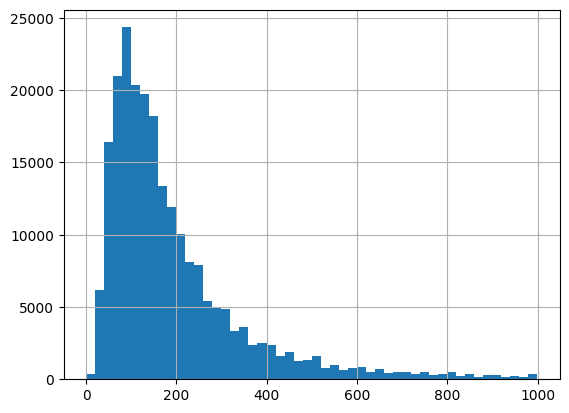

In [73]:
df[df.price<1000]['price'].hist(bins=50)

In [74]:
df[df.price>5000].shape, df.shape

((494, 19), (232147, 19))

<Axes: >

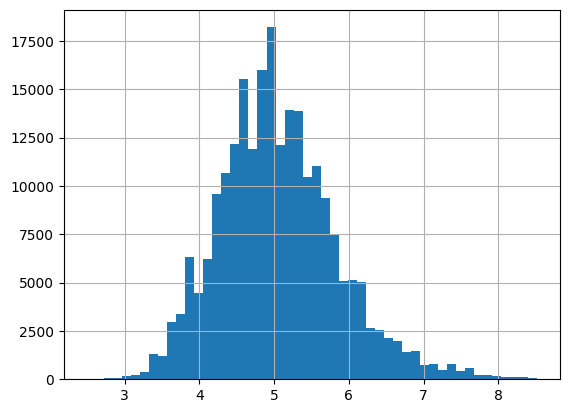

In [65]:
df[(df.price<5000) & (df.price>10)]['price_log'].hist(bins=50)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['price', 'price_log']), X['price'], test_size=0.2, random_state=42)

In [87]:
param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05], 'max_depth': [5, 10], 
              'subsample': [0.8, 0.6], 'min_samples_split': [2, 3]}
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.05], 'max_depth': [5, 10],
                         'min_samples_split': [2, 3],
                         'n_estimators': [100, 200], 'subsample': [0.8, 0.6]},
             scoring='neg_root_mean_squared_error')

In [88]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse:.2f}")
print("Best params:", grid_search.best_params_)

Test RMSE: 231.63
Best params: {'learning_rate': 0.05, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200, 'subsample': 0.8}


In [89]:
r2 = r2_score(y_test, y_pred)
print(f"Test R²: {r2:.3f}")

Test R²: 0.426


In [ ]:
#It got better when I added additional parameters in Grid, from 0.352

In [93]:
results_df = pd.DataFrame(grid_search.cv_results_)
results_df = results_df.sort_values(by='mean_test_score', ascending=False)
results_df.head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_min_samples_split,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
26,101.047207,0.307365,0.450111,0.023690,0.05,10,2,200,0.8,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",-233.538890,-233.659147,-231.681923,-232.959987,0.905060,1
30,83.176886,1.048965,0.365876,0.007021,0.05,10,3,200,0.8,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",-233.646656,-233.895423,-231.612152,-233.051410,1.022764,2
31,62.249352,1.561958,0.376013,0.003577,0.05,10,3,200,0.6,"{'learning_rate': 0.05, 'max_depth': 10, 'min_...",-232.958742,-235.297316,-231.440572,-233.232210,1.586339,3


I also changed: predict price_log (as its normally distributed)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['price_log', 'price']), X['price_log'], test_size=0.2, random_state=42)

In [102]:
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)
param_grid = {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05, 0.01], 'max_depth': [3, 5, 10, 15], 'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8, 1.0], 'min_child_weight': [1, 3, 5]}
grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=3, scoring='neg_root_mean_squared_error',
                           verbose=0, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.3f}")
print("Best params:", grid_search.best_params_)

Test RMSE: 0.49
Test R²: 0.618
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 15, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}


Thats a much better result! 

### SHAP - SHapley Additive exPlanations - it’s a method to explain the output of machine learning models, especially complex ones like XGBoost, LightGBM, RandomForest, neural nets, etc.
Y-axis: list of features, ordered by importance.  
X-axis: SHAP value: how much this feature pushed the prediction up (right) or down (left) relative to the average prediction.  
Color: Red = high value, Blue = low value

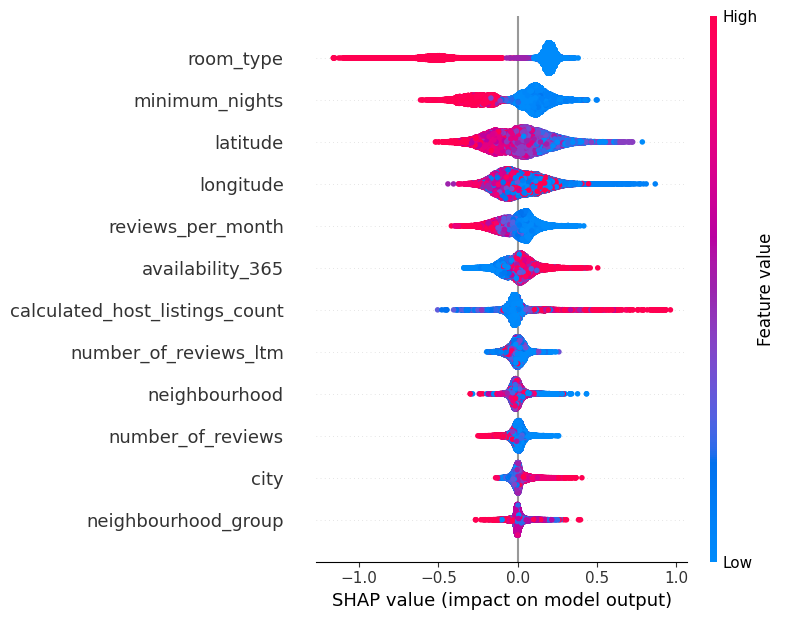

In [106]:
explainer = shap.Explainer(best_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

#### Room_type: high values (red, e.g., “Entire home”) tend to increase price predictions; low values (blue, e.g., “Shared room”) decrease price predictions.
#### Minimum_nights: low values (blue) seem to push predictions higher slightly — odd, possibly noise.
#### Latitude and longitude: location clearly impacts price (e.g., some areas are cheaper or more expensive).
#### Reviews_per_month: medium/high values slightly increase price — maybe hosts with more activity command more.

In [108]:
shap.initjs()
shap.force_plot(shap_values[0])

#### Base value: ~5.04 (log(price), the average log‑prediction for the dataset).
#### Final prediction: ~4.27 (So the model predicted a lower‑than‑average price for this listing.)
Blue arrows: these features pushed the prediction down. Red arrows: these features pushed it up. => 
1. minimum_nights=1: pushed price higher.
2. room_type=2 (“Private room”): pushed price lower.
3. Other features (reviews_per_month, latitude, etc.) each had smaller contributions.

In [113]:
encoders['room_type'].inverse_transform([2])[0]

'Private room'

# SUMMARY

Target variable price was highly skewed; log‑transform normalized it.
Baseline GradientBoostingRegressor achieved RMSE: 231.63, R²: 0.426.
Switching to price_log as target and using XGBRegressor improved results to RMSE: 0.49 (log scale) and R²: 0.618.


Next steps / recommendations:

1. Segment users based on room type: Since prices differ significantly by room type, segment users accordingly and target each audience with tailored marketing campaigns to maximize engagement and conversion.
2. Enhance geographic feature engineering: To better capture the effect of location, create derived features such as distance to city center, tourist attractions, or key neighborhoods, instead of relying solely on raw latitude and longitude.
3. Choose appropriate models for high-cardinality features: The neighbourhood feature has many unique categories. For tree-based models, this is handled well, but for regression models it’s advisable to normalize the data and replace neighbourhood with engineered rates or grouped categories to avoid overfitting.
4. Support and incentivize active hosts: Listings with higher reviews_per_month achieve better pricing. Encourage host activity and responsiveness through targeted incentives, as engagement correlates strongly with perceived value and pricing power.

In [114]:
for col, le in encoders.items():
    print(f"\n{col}:")
    print({idx: label for idx, label in enumerate(le.classes_)})


neighbourhood_group:
{0: 'Ballard', 1: 'Beacon Hill', 2: 'Bristol', 3: 'Bronx', 4: 'Brooklyn', 5: 'Capitol Hill', 6: 'Cascade', 7: 'Central Area', 8: 'City of Los Angeles', 9: 'Delridge', 10: 'Downtown', 11: 'Interbay', 12: 'Kent', 13: 'Lake City', 14: 'Magnolia', 15: 'Manhattan', 16: 'NA', 17: 'Newport', 18: 'Northgate', 19: 'Other Cities', 20: 'Other neighborhoods', 21: 'Providence', 22: 'Queen Anne', 23: 'Queens', 24: 'Rainier Valley', 25: 'Seward Park', 26: 'Staten Island', 27: 'Unincorporated Areas', 28: 'University District', 29: 'Washington', 30: 'West Seattle'}

neighbourhood:
{0: '28704', 1: '28715', 2: '28732', 3: '28801', 4: '28803', 5: '28804', 6: '28805', 7: '28806', 8: '78701', 9: '78702', 10: '78703', 11: '78704', 12: '78705', 13: '78712', 14: '78717', 15: '78719', 16: '78721', 17: '78722', 18: '78723', 19: '78724', 20: '78725', 21: '78726', 22: '78727', 23: '78728', 24: '78729', 25: '78730', 26: '78731', 27: '78732', 28: '78733', 29: '78734', 30: '78735', 31: '78736', 